<a href="https://colab.research.google.com/github/alekswheeler/global-_species_abundance_and_diversity/blob/main/AquecimentoGlobalEAbumdanciaDeEspecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Este trabalho teve como objetivo analisar e processar um conjunto de dados relacionado ao risco de extinção de espécies, com base no estudo [*“Estimating Extinction Risks with Species Occurrence Data from the Global Biodiversity Information Facility” (Dasgupta, Blankespoor e Wheeler, 2024)*](https://openknowledge.worldbank.org/server/api/core/bitstreams/dac7c5d6-6f4e-4c9a-82b7-22d7c85aa870/content)  . A partir de dados provenientes do [Global Biodiversity Species Extinction Risks Data - Worldbank](https://www.google.com/url?q=https%3A%2F%2Fdatacatalog.worldbank.org%2Fsearch%2Fdataset%2F0066034%2FGlobal-Biodiversity-Data), foram exploradas variáveis que influenciam o risco de extinção, tais como a densidade populacional, a intensidade da pesca, a proteção formal em áreas protegidas e a probabilidade de ameaça. Além disso, foram incluídas informações sobre o estado de conservação das espécies, conforme categorizado pela Lista Vermelha da IUCN, como "Criticamente Ameaçada", "Vulnerável" e "Dados Deficientes".


## Definição do problema

O objetivo principal do trabalho é desenvolver um modelo de classificação que possa prever o status de conservação de espécies (por exemplo, "em perigo", "vulnerável", "criticamente em perigo") com base em características biológicas, ecológicas e geográficas obtidas de bases de dados públicas.

Bases de Dados
- IUCN Red List: A Lista Vermelha da União Internacional para a Conservação da Natureza (IUCN) é uma das fontes mais completas sobre o status de conservação de espécies.

- GBIF (Global Biodiversity Information Facility): Fornece dados sobre a distribuição geográfica de espécies.

## Descrição do conjunto de dados

In [2]:
pip install pygbif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.7 MB/s eta 0:00:00


Variáveis utilizadas na análise do artigo [*“Estimating Extinction Risks with Species Occurrence Data from the Global Biodiversity Information Facility”*](https://openknowledge.worldbank.org/server/api/core/bitstreams/dac7c5d6-6f4e-4c9a-82b7-22d7c85aa870/content)  (Dasgupta, Blankespoor e Wheeler, 2024).  

As variáveis analisadas incluem:  

- **Espécies:**  
  - **species:** espécies com dados de ocorrência no GBIF.  
  - **d_assignedrisk:** indicação se a espécie está listada na Lista Vermelha da IUCN (1 para sim, 0 para não).  

- **Ameaças:** fatores que influenciam o risco de extinção, como:  
  - **parkpct:** índice de proteção formal, calculado com base na presença da espécie em áreas protegidas.  
  - **popdens:** densidade populacional, medida em um raster espacial dividido em 15 grupos.  
  - **eezpct:** percentual da área de ocorrência da espécie dentro de Zonas Econômicas Exclusivas (EEZ).  
  - **popshadow:** influência populacional costeira, baseada na projeção de dados terrestres sobre áreas marítimas.  
  - **totfishing:** intensidade total da pesca, estimada por monitoramento via satélite e sistemas AIS.  
  - **natfishing:** intensidade da pesca considerando impactos ambientais, calculada a partir de imagens de satélite.  
  - **pthreat:** índice de probabilidade de ameaça, variando de 0 a 100.  
  - **popgroupmax:** grupo máximo de densidade populacional, classificado em uma escala de 1 a 15.  
  - **lcat** variável que descreve o habitat da espécie, exemplo: ocean, coast

O estudo utiliza dados de diversas fontes, incluindo a IUCN, Global Fishing Watch e bases de dados espaciais, para estimar riscos de extinção com base na ocorrência das espécies.

Por conta do tamanho do conjunto de dados a importaçao é feita buscando o dado diretamente em algum serviço de armazenamento

In [3]:
import os
import zipfile
import requests

# 🔗 URL do Dropbox (modificada para permitir download direto)
dropbox_url = "https://www.dropbox.com/scl/fi/uanikg1a1jklpjyzl5j0x/global_biod_species_extinction_risks.zip?rlkey=fmb0q5n8tth1cvw9rt93a25n4&e=2&st=8iex1p7w&dl=1"

# 📂 Nome do arquivo ZIP localmente no Colab
zip_path = "dataset.zip"

# ⬇️ Baixa o arquivo ZIP do Dropbox
response = requests.get(dropbox_url)
with open(zip_path, "wb") as f:
    f.write(response.content)

print("✅ Download concluído!")

# 📂 Pasta de extração
extract_folder = "/content/dataset_csvs"
os.makedirs(extract_folder, exist_ok=True)

# 🔄 Extrai todos os arquivos CSV do ZIP
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

# 🔍 Lista os arquivos extraídos
csv_files = [f for f in os.listdir(extract_folder) if f.endswith(".csv")]

print("\n📂 Arquivos CSV extraídos:")
for file in csv_files:
    print(f"- {file}")

print("\n✅ Extração concluída! Todos os CSVs estão em:", extract_folder)


✅ Download concluído!

📂 Arquivos CSV extraídos:
- global_biod_species_extinction_risks.csv

✅ Extração concluída! Todos os CSVs estão em: /content/dataset_csvs


Como o conjunto original tem muitos dados, optamos por escolher aleatoriamente alguns dados do conjunto original para fazer a análise. Não é possível estratitificar essa escolha considerando a classe pois o conjunto original não tem essas informações apenas o ID de cada espécie.

In [4]:
import pandas as pd

SEED = 432

df = pd.read_csv("/content/dataset_csvs/global_biod_species_extinction_risks.csv")

df = df.sample(n=800, random_state=SEED)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 151876 to 483365
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   species         800 non-null    object 
 1   parkpct         800 non-null    float64
 2   popden          751 non-null    float64
 3   eezpct          231 non-null    float64
 4   popshadow       231 non-null    float64
 5   totfishing      231 non-null    float64
 6   natfishing      230 non-null    float64
 7   popgroupmax     790 non-null    float64
 8   pthreat         800 non-null    float64
 9   d_assignedrisk  800 non-null    float64
 10  lcat            800 non-null    object 
dtypes: float64(9), object(2)
memory usage: 75.0+ KB


Adicionando as features de Class, kingdom e [IUCNRedListCategory](https://en.wikipedia.org/wiki/IUCN_Red_List#Categories) que basicamente indica qual o estado de conservaçao das espécies.

- **Extinto (EX)** – para além de qualquer dúvida razoável de que a espécie já não existe.
- **Extinto na natureza (EW)** – sobrevive apenas em cativeiro, cultivo e/ou fora da área de distribuição nativa, como presumido após inquéritos exaustivos.
- **Criticamente ameaçada (CR)** – num estado particularmente e extremamente crítico.
- **Ameaçado (EN)** – risco muito elevado de extinção na natureza, satisfaz qualquer um dos critérios A a E para a extinção em perigo.
- **Vulnerável (VU)** – cumpre um dos 5 critérios da Lista Vermelha e, por conseguinte, é considerada como estando em elevado risco de extinção não natural (causada pelo homem) sem intervenção humana adicional.
- **Quase Ameaçado (NT)** – perto de estar em perigo num futuro próximo.
- **Menor Risco (LR)** – é improvável que se torne ameaçada ou extinta num futuro próximo.
- **Dados Deficientes (DD)**
- **Não Avaliado (NE)**

In [5]:
import requests
import pandas as pd

def get_species_info(scientific_name):
    url = f"https://api.gbif.org/v1/species/match?scientificName={scientific_name}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("usageKey"), data.get("class"), data.get("kingdom")
    else:
        print(f"Erro ao buscar dados para {scientific_name}: {response.status_code}")
        return None, None, None

def get_iucn_category(usage_key):
    url = f"https://api.gbif.org/v1/species/{usage_key}/iucnRedListCategory"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get("category")
    else:
        print(f"Erro ao buscar categoria IUCN para usageKey {usage_key}: {response.status_code}")
        return None

def enrich_dataframe(df):
    df["Class"] = None
    df["Kingdom"] = None
    df["IUCNRedListCategory"] = None

    for index, row in df.iterrows():
        usage_key, class_name, kingdom = get_species_info(row["species"])
        df.at[index, "Class"] = class_name
        df.at[index, "Kingdom"] = kingdom

        if usage_key:
            iucn_category = get_iucn_category(usage_key)
            df.at[index, "IUCNRedListCategory"] = iucn_category

    return df

df = enrich_dataframe(df)

Erro ao buscar categoria IUCN para usageKey 4908866: 204
Erro ao buscar categoria IUCN para usageKey 2642861: 204
Erro ao buscar categoria IUCN para usageKey 1043590: 204
Erro ao buscar categoria IUCN para usageKey 10785196: 204
Erro ao buscar categoria IUCN para usageKey 10045365: 204
Erro ao buscar categoria IUCN para usageKey 11118524: 204


In [6]:
df_original = df.copy()

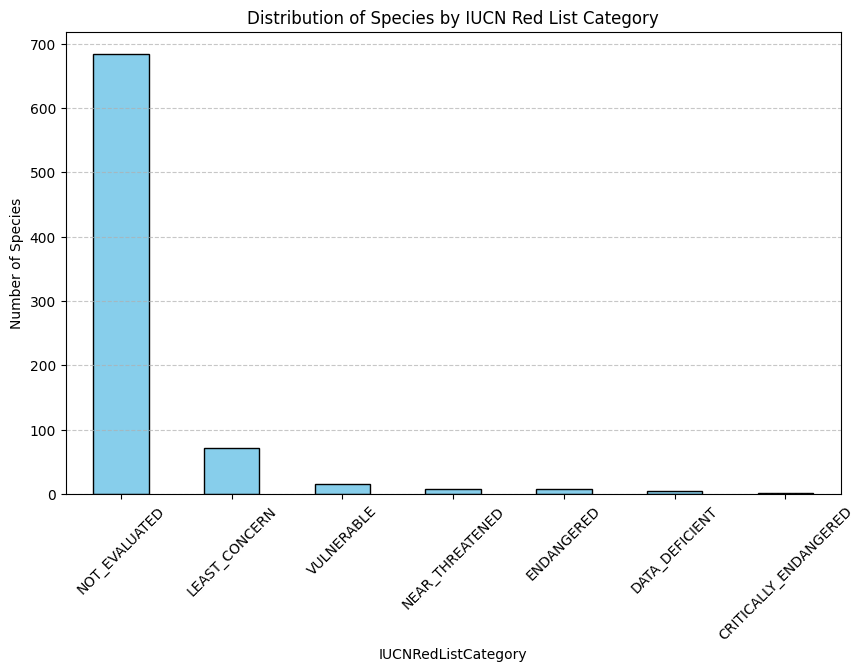

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_iucn_distribution(df, title, feature):
    plt.figure(figsize=(10, 6))
    df[feature].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel("Number of Species")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_iucn_distribution(df, "Distribution of Species by IUCN Red List Category", "IUCNRedListCategory")

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_heatmap(df, x_feature, y_feature):
    """
    Gera um mapa de calor cruzando duas features categóricas.

    Parâmetros:
    - df: DataFrame do Pandas
    - x_feature: Nome da coluna a ser usada no eixo X
    - y_feature: Nome da coluna a ser usada no eixo Y
    """
    # Criando a tabela cruzada (contagem de ocorrências)
    heatmap_data = pd.crosstab(df[y_feature], df[x_feature])

    # Criando o mapa de calor
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt="d", linewidths=0.5)

    # Configurando os rótulos
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f"Mapa de Calor: {y_feature} vs {x_feature}")

    # Exibir o gráfico
    plt.show()


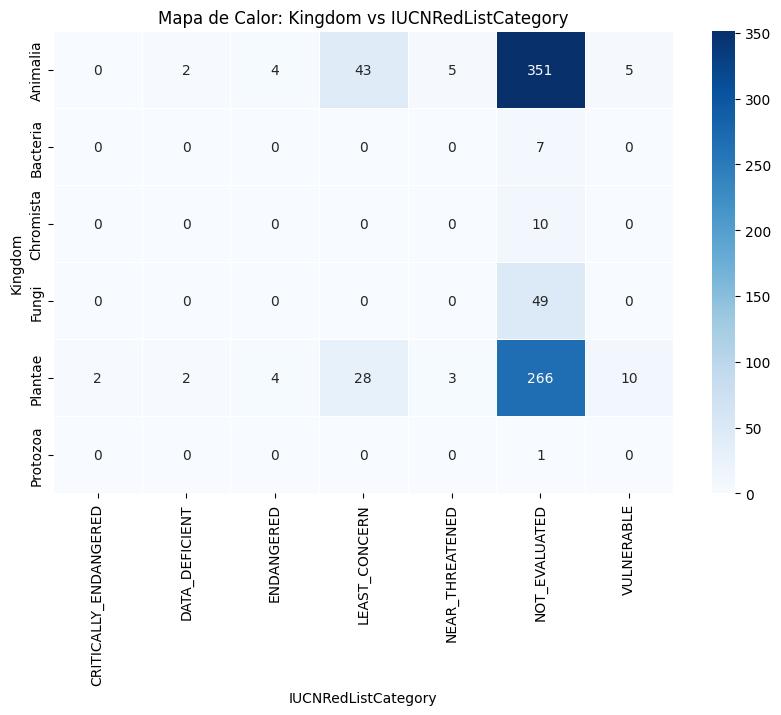

In [9]:
plot_heatmap(df, "IUCNRedListCategory", "Kingdom")  # Mapa de calor entre categoria de risco e reino

# Metodologia

## Pré processamento

Algumas classes possuem pouquíssimos indivíduos, mas podem ser agrupadas pois todas representam espécies em risco. Aqui uma imagem mostrando a referência para o agrupamento.

In [10]:
df["IUCNRedListCategory"].unique()

array(['LEAST_CONCERN', 'NOT_EVALUATED', 'CRITICALLY_ENDANGERED',
       'ENDANGERED', 'NEAR_THREATENED', None, 'VULNERABLE',
       'DATA_DEFICIENT'], dtype=object)

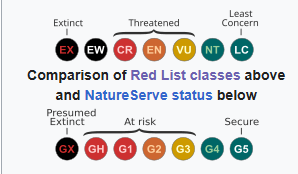

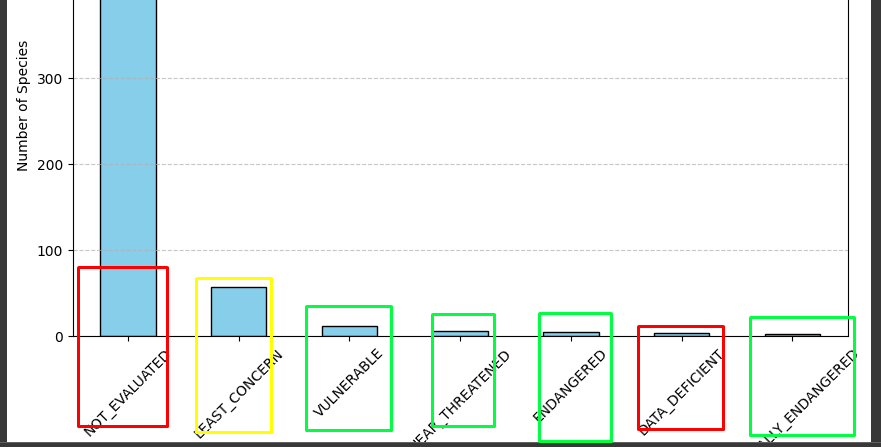

In [11]:
df["IUCNRedListCategory"] = df["IUCNRedListCategory"].fillna("NOT_EVALUATED")

# Criando um dicionário de mapeamento
category_mapping = {
    "NOT_EVALUATED": "Unknown",
    "DATA_DEFICIENT": "Unknown",
    "LEAST_CONCERN": "Low Risk",
    "CRITICALLY_ENDANGERED": "Threatened",
    "ENDANGERED": "Threatened",
    "NEAR_THREATENED": "Threatened",
    "VULNERABLE": "Threatened"
}

# Aplicando o mapeamento
df["GroupedCategory"] = df["IUCNRedListCategory"].map(category_mapping)

Abaixo a nova distribuição de classses considerando a referência para o agrupamento.

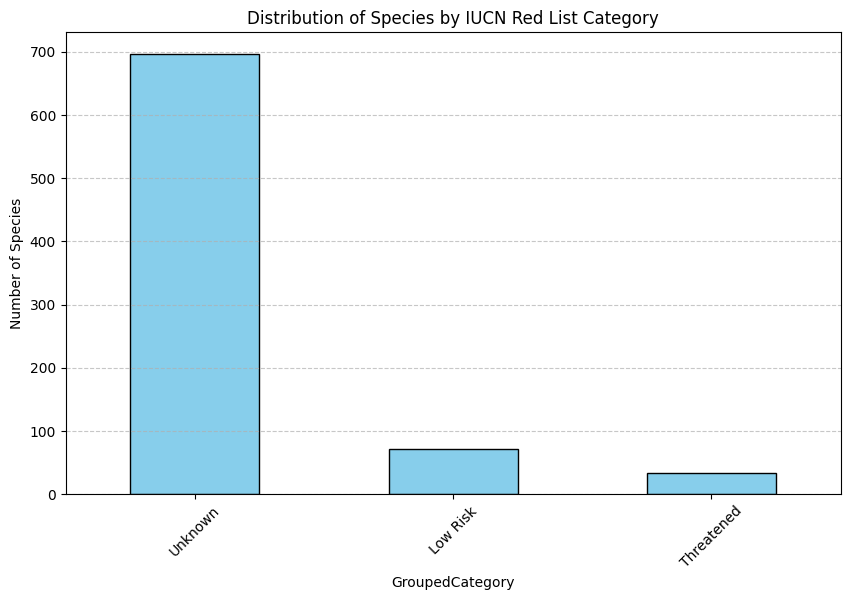

In [12]:
plot_iucn_distribution(df, "Distribution of Species by IUCN Red List Category", "GroupedCategory")

Vamos remover algumas colunas que possam causar viés nos classificadores. Por exemplo as colunas Kingdom e Class são apenas para fornecer uma visualizaçao melhor dos dados. E a coluna IUCNRedListCategory é o nosso Target.

A coluna species é irrelevante no momento pois é basicamente o ID de cada entrada do dataSet. A coluna d_assignedrisk tem dados da possibilidade de ameaça da espécie, assim como pthreat. A coluna lcat é o habitat da spécie, pode ser que influencie o agrupamento por habitat, mas não é o objetivo.

In [13]:
df_species = df.copy()
df_species = df_species.drop(columns=['Class', 'Kingdom', 'IUCNRedListCategory','species', 'lcat', 'GroupedCategory', 'd_assignedrisk', 'pthreat'])

A normalização de dados uma das etapas do pré-processamento. Neste trabalho, o código realiza a normalização Min-Max, que transforma os valores das colunas numéricas para um intervalo entre 0 e 100, preservando a distribuição original dos dados. Antes da normalização, o código verifica e trata valores nulos, preenchendo-os com a média nas colunas numéricas e com o valor "Desconhecido" nas colunas categóricas.

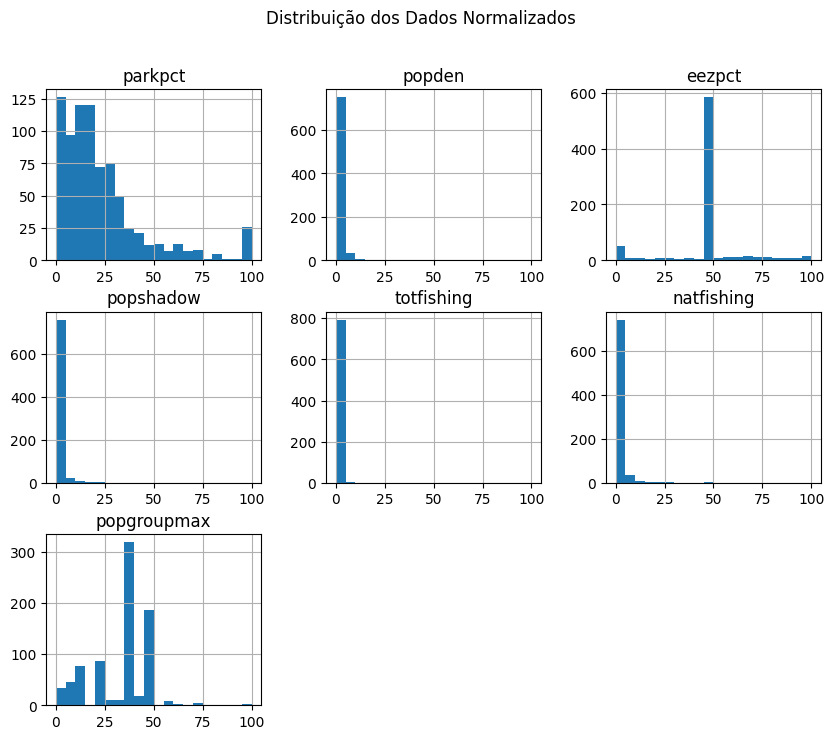

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# removendo NaN
# Lista das colunas numéricas com valores NaN
colunas_com_nan = ['parkpct', 'popden', 'eezpct', 'popshadow', 'totfishing',
                   'natfishing', 'popgroupmax']

# Preenchendo os NaN com a média da respectiva coluna
for coluna in colunas_com_nan:
    df_species[coluna] = df_species[coluna].fillna(df_species[coluna].mean())

# --- Normalizando os dados ---
scaler = MinMaxScaler(feature_range=(0,100))
df_normalized = scaler.fit_transform(df_species)

df_species = pd.DataFrame(scaler.fit_transform(df_species), columns=df_species.columns)

# 9. Plotar a distribuição dos dados normalizados
df_species.hist(bins=20, figsize=(10, 8))
plt.suptitle('Distribuição dos Dados Normalizados')
plt.show()

## Visualização de dados

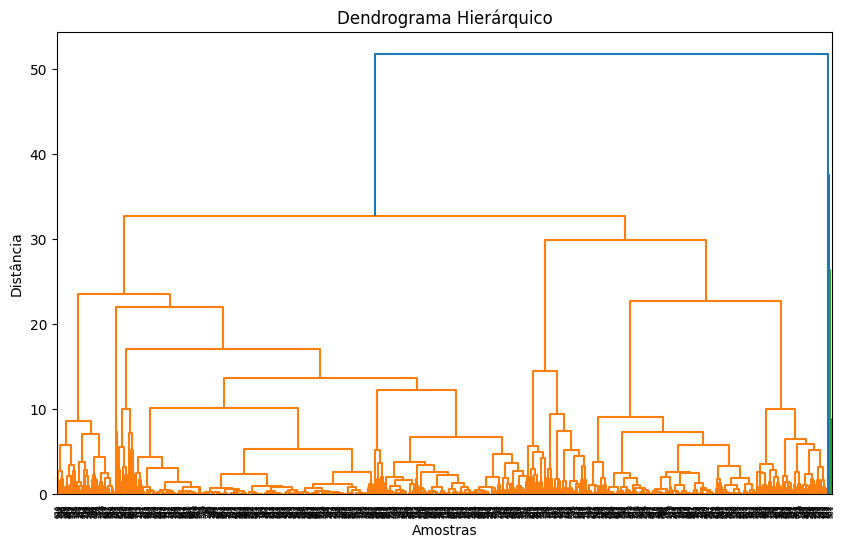

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering


# --- 1️⃣ Normalizando os dados ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_species)

# --- 2️⃣ Calculando a ligação e criando o Dendrograma ---
linked = linkage(df_scaled, method='ward')  # Método Ward

plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title('Dendrograma Hierárquico')
plt.xlabel('Amostras')
plt.ylabel('Distância')
plt.show()

# --- 3️⃣ Aplicando o Agrupamento Hierárquico Aglomerativo ---
n_clusters = 3  # Defina o número de clusters que você deseja

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df_species['Cluster'] = agg_clustering.fit_predict(df_scaled)

## Classificação

### Validaçao cruzada

As categorias de risco foram transformadas em valores numéricos para usar no treinamento do classificador

In [16]:
from sklearn.preprocessing import LabelEncoder

# Criando um LabelEncoder
le = LabelEncoder()

# df["GroupedCategory"] = df["GroupedCategory"].fillna("NOT_EVALUATED")
df["Risk"] = le.fit_transform(df["GroupedCategory"])

X = df_species
y = df['Risk']

In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import f1_score, make_scorer

# Definição dos hiperparâmetros a serem testados
param_grid = {
    "n_clusters": [3, 4, 5, 6, 7]
}

# Criando um classificador
clf = KMeans(random_state=33)

def do_cross_validate(clf, test_size, df, X, y, paran_grid):
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.33, random_state=42)

  # Criando Stratified K-Fold para manter a proporção das classes
  strat_kfold = RepeatedStratifiedKFold(n_splits=2, random_state=42)

  # Criando um scorer personalizado para usar no GridSearchCV
  f1_weighted_scorer = make_scorer(f1_score, average="weighted", zero_division=0)

  # Criando o GridSearchCV
  grid_search = GridSearchCV(clf, param_grid, cv=strat_kfold, scoring=f1_weighted_scorer, n_jobs=-1)

  # Treinando o modelo
  grid_search.fit(X, y)

  # Exibir os melhores parâmetros e resultado
  print("Melhores parâmetros:", grid_search.best_params_)
  print("Melhor F1-Score:", grid_search.best_score_)

do_cross_validate(clf, 0.33, df, X, y, param_grid)

Melhores parâmetros: {'n_clusters': 3}
Melhor F1-Score: 0.21632732123325268


In [ ]:
from sklearn.cluster import SpectralClustering

clf = SpectralClustering(n_clusters=2,
        assign_labels='discretize',
        random_state=0).fit(X)

param_grid = {
    "n_clusters": [3, 4, 5, 6, 7],
    "assign_labels": ['kmeans', 'discretize']
}

do_cross_validate(clf, 0.33, df, X, y, param_grid)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


# Conclusão

### Conclusão

Durante o pré-processamento dos dados, foram realizadas etapas fundamentais para garantir a qualidade da análise. Valores nulos foram tratados, preenchendo-se colunas numéricas com a média e colunas categóricas com o valor "Desconhecido". A normalização Min-Max foi aplicada para escalonar as variáveis numéricas em um intervalo entre 0 e 100, garantindo que todas as colunas estivessem em uma escala uniforme e adequada para análises posteriores. Além disso, colunas irrelevantes ou que poderiam introduzir viés, como "Kingdom" e "Class", foram removidas, enquanto a coluna "IUCNRedListCategory" foi definida como o target para classificação.

Um dos desafios enfrentados foi o desbalanceamento do conjunto de dados, com algumas categorias de risco apresentando poucos indivíduos. Para contornar esse problema, optou-se por agrupar categorias semelhantes e remover registros cuja classificação era desconhecida, garantindo maior consistência e relevância para a análise. A visualização dos dados, por meio de gráficos e histogramas, permitiu identificar padrões e distribuições, facilitando a compreensão das características do conjunto de dados.

Em síntese, este trabalho demonstrou a importância de um pré-processamento cuidadoso e de técnicas de normalização para a análise de dados complexos e desbalanceados. As etapas realizadas, desde a limpeza e tratamento de valores nulos até a normalização e agrupamento de categorias, foram essenciais para preparar o conjunto de dados para futuras análises preditivas ou classificatórias. A abordagem adotada não apenas contribui para a estimativa de riscos de extinção, mas também serve como base para estudos similares que envolvam dados de biodiversidade e conservação. Futuros trabalhos podem explorar a aplicação de algoritmos de machine learning para prever riscos de extinção ou identificar fatores críticos que impactam a sobrevivência das espécies, utilizando o conjunto de dados preparado neste estudo.

## Discussãocação dos Resultados

# Video


Um vídeo (de aproximadamente 5 minutos) descrevendo o trabalho e os resultados. Pretendo divulgar esse vídeo para os demais colegas da disciplina e para os professores do DI. **Os vídeos são apenas para facilitar a correção e não serão publicados!**

# Referências

https://techdocs.gbif.org/en/openapi/

https://datacatalog.worldbank.org/search/dataset/0066034/Global-Biodiversity-Data